<a href="https://colab.research.google.com/github/lisa3579/Client-clustering-using-r/blob/main/Client_clustering_using_r.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 💾 The data

The company stores the information you need in the following four tables. Some of the fields are anonymized to comply with privacy regulations.

#### Doctors contains information on doctors. Each row represents one doctor.
- "DoctorID" - is a unique identifier for each doctor.
- "Region" - the current geographical region of the doctor.
- "Category" - the type of doctor, either 'Specialist' or 'General Practitioner.'
- "Rank" - is an internal ranking system. It is an ordered variable: The highest level is Ambassadors, followed by Titanium Plus, Titanium, Platinum Plus, Platinum, Gold Plus, Gold, Silver Plus, and the lowest level is Silver.
- "Incidence rate"  and "R rate" - relate to the amount of re-work each doctor generates.
- "Satisfaction" - measures doctors' satisfaction with the company.
- "Experience" - relates to the doctor's experience with the company.
- "Purchases" - purchases over the last year.

#### Orders contains details on orders. Each row represents one order; a doctor can place multiple orders.
- "DoctorID" - doctor id (matches the other tables).
- "OrderID" - order identifier.
- "OrderNum" - order number.
- "Conditions A through J" - map the different settings of the devices in each order. Each order goes to an individual patient.

#### Complaints collects information on doctor complaints.
- "DoctorID" - doctor id (matches the other tables).
- "Complaint Type" - the company's classification of the complaints.
- "Qty" - number of complaints per complaint type per doctor.

#### Instructions has information on whether the doctor includes special instructions on their orders.
- "DoctorID" - doctor id (matches the other tables).
- "Instructions" - 'Yes' when the doctor includes special instructions, 'No' when they do not.

# Top insights from the analysis
- Average number of Purchases for a client is 13
- There is weak positive correlation between amount of Purchases and Complaints, but there are also other parameters which correlate with Purchases more
- We discovered 4 clusters of clients based on given data, analysed every cluster, highlighted their main features and offered several changes in communication strategy with them 
- Key parameters for clusering are Category of Doctor, Instructions and amount of Complains
- Those clients who add Instructions to their order are more satisfied with the company
- General Practitioners form separate cluster which is different with small number of Purchases and one of the greatest Experiences with the company

# 0. Prepare necessary libraries and read csvs

In [1]:
library(dplyr)
library(ggplot2)
library(datasets)
library(magrittr)
install.packages("packcircles")
library(packcircles)
install.packages("gridExtra")
library(gridExtra)
install.packages('factoextra')
library(factoextra)
install.packages("fpc")
library(fpc)
install.packages('reshape2')
library(reshape2)
install.packages('clusterSim')
library(clusterSim)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)


Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Welcome! Want to learn more? See two factoextra-related books at https://goo.gl/ve3WBa

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Loading required package: cluster

Loading required package: MASS


Attaching package: ‘MASS’


The following o

In [2]:
suppressPackageStartupMessages(library(tidyverse))
doctors <- readr::read_csv('/doctors.csv', show_col_types = FALSE)
orders <- readr::read_csv('/orders.csv', show_col_types = FALSE)
complaints <- readr::read_csv('/complaints.csv', show_col_types = FALSE)
instructions <- readr::read_csv('/instructions.csv', show_col_types = FALSE)

Warning message in system("timedatectl", intern = TRUE):
“running command 'timedatectl' had status 1”


# 1. How many doctors are there in each region? What is the average number of purchases per region?
We can get this information from the first table (doctors). There are too much regions given, so the bubble plot is better to show which regions have less or more doctors. The bigger size of the bubble the more doctors in the region:


   1 10 1 10 T3    1 11    1 12 1 12 T3 1 12 T4    1 13 1 13 T3 1 13 T4    1 14 
     15       8      23      23       6       2      34      11       1      32 
1 14 T3 1 14 T4    1 19 1 19 20 1 19 T3 1 19 T4 1 21 T3 1 21 T4   1 4CP     1 8 
     15       4      31       1      13       9       4       2       1      21 
 1 8 T3  1 8 T4     1 9  1 9 T3  1 9 T4      17    2 11  2 6 10  2 6 12  2 6 13 
     14       6      32      11       7       6       9       1       5       6 
 2 6 14  2 6 19   2 6 8   2 6 9  2 7 10  2 7 12  2 7 13  2 7 14  2 7 19   2 7 8 
      2       5       4       5       7       6       6       7      14       5 
  2 7 9   22 18    23 3    3 16    4 15    5 18 
      8       7       1       1       3       3 

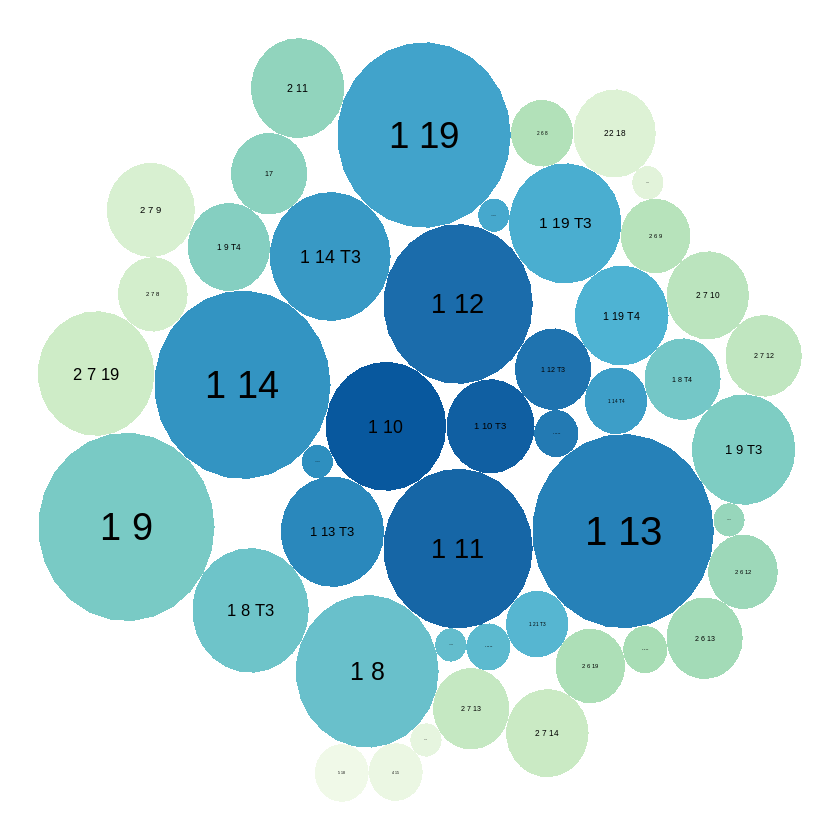

In [3]:
table(doctors$Region)
docs_by_region <- as.data.frame(table(doctors$Region))
docs_by_region_size <- circleProgressiveLayout(docs_by_region$Freq*50)
docs_by_region_plot <- circleLayoutVertices(docs_by_region_size)
ggplot(docs_by_region_plot, aes(x, y)) + 
  geom_polygon(aes(group = id, fill = id), 
                show.legend = FALSE) +
  geom_text(data = docs_by_region_size, aes(x, y), label = docs_by_region$Var1, size=docs_by_region$Freq/4) +
  scale_fill_distiller(palette = "GnBu") +
  theme_void()


The plot above shows that there are several regions with relatively large number of doctors (7 regions with more than 20 doctors) and many regions with quite a little number of specialists (18 regions with 5 or less doctors)

Average number of purchases by doctor is about 13 items. Average number of purchases by region is about 103 items. The plot below shows average number of ordered items per doctor during last year distributed by region:

[1] 13.1093

[1] 102.5217

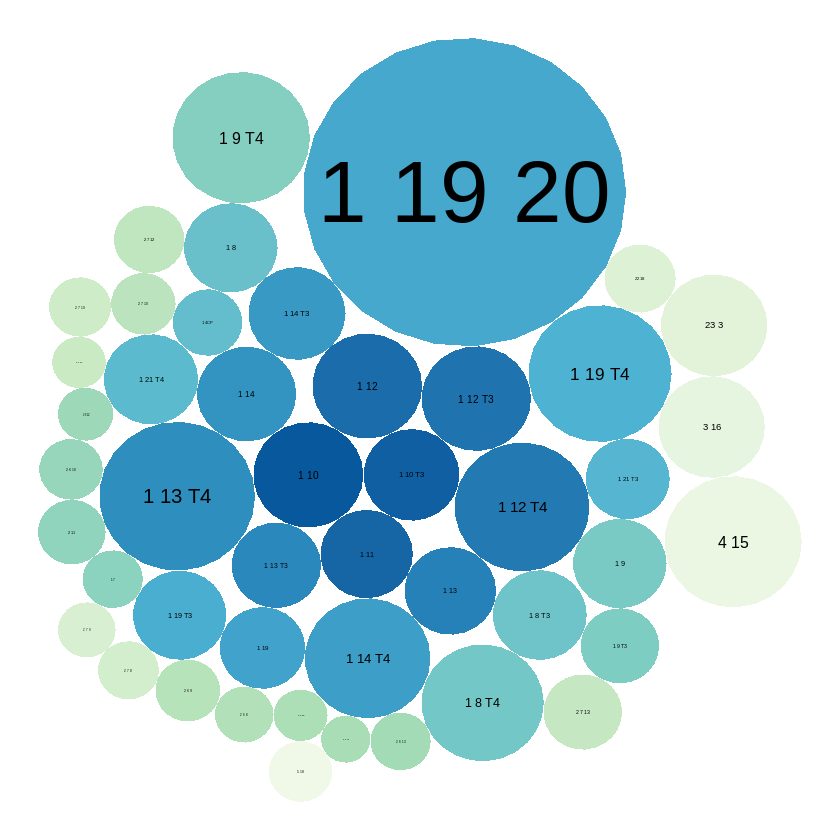

In [4]:
docs_purchases <- dplyr::select(doctors, Region)%>% count(Region)
docs_purchases$purchases_sum <- tapply(doctors$Purchases, doctors$Region, sum)
docs_purchases$purchases_avg <- docs_purchases$purchases_sum/docs_purchases$n
mean(docs_purchases$purchases_avg)
mean(docs_purchases$purchases_sum)

docs_purchases_size <- circleProgressiveLayout(docs_purchases$purchases_avg)
docs_purchases_plot <- circleLayoutVertices(docs_purchases_size)

ggplot(docs_purchases_plot, aes(x, y)) + 
  geom_polygon(aes(group = id, fill = id), 
                show.legend = FALSE) +
  geom_text(data = docs_purchases_size, aes(x, y), label = docs_purchases$Region, size=docs_purchases$purchases_avg/7) +
  scale_fill_distiller(palette = "GnBu") +
  theme_void()

# 2. Can you find a relationship between purchases and complaints?
If the company wants to improve marketing and customer service, it's important to get to know what affects the number of purchases and comlaints. 
Here we want to check if the number of complaints is related to the number of sales.

In [5]:
# prepare the data
docs_complaints <- dplyr::select(complaints,DoctorID) 
docs_complaints <- tapply(complaints$Qty,complaints$DoctorID,sum)
docs_complaints <- as.data.frame(docs_complaints)
docs_complaints <- setNames(cbind(rownames(docs_complaints), docs_complaints, row.names = NULL), 
         c("doc", "compl"))
# count the number of complaints by every doctor
docs_purchases <- dplyr::select(doctors,DoctorID)
docs_purchases <- tapply(doctors$Purchases,doctors$DoctorID,sum)
docs_purchases <- as.data.frame(docs_purchases)
docs_purchases <- setNames(cbind(rownames(docs_purchases), docs_purchases, row.names = NULL), 
         c("doc", "purch"))
complaints_purchases <- merge(docs_purchases,docs_complaints,by='doc',all=TRUE)
complaints_purchases$compl[is.na(complaints_purchases$compl)] <- 0
complaints_purchases <- na.omit(complaints_purchases)
# merge 2 tables with purchases and complaints by every doctor, if there were no complaints we put 0, if there were no purchases we deleted these rows

In [6]:
cor.test(complaints_purchases$compl,complaints_purchases$purch,method = 'spearman') # spearman coefficient is mostly used with nonparametric data 
cor.test(complaints_purchases$compl,complaints_purchases$purch,method = 'kendall')
cor.test(complaints_purchases$compl,complaints_purchases$purch)
# we also calculated other popular correlation coefficients

Warning message in cor.test.default(complaints_purchases$compl, complaints_purchases$purch, :
“Cannot compute exact p-value with ties”



	Spearman's rank correlation rho

data:  complaints_purchases$compl and complaints_purchases$purch
S = 12052905, p-value = 0.005207
alternative hypothesis: true rho is not equal to 0
sample estimates:
      rho 
0.1334354 



	Kendall's rank correlation tau

data:  complaints_purchases$compl and complaints_purchases$purch
z = 2.7773, p-value = 0.005481
alternative hypothesis: true tau is not equal to 0
sample estimates:
      tau 
0.1089525 



	Pearson's product-moment correlation

data:  complaints_purchases$compl and complaints_purchases$purch
t = 3.3089, df = 435, p-value = 0.001014
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.06382426 0.24686698
sample estimates:
      cor 
0.1566908 


For the sake of completeness, we carried out 3 correlation tests. Correlation coefficients show very weak positive correlation between the number of purchases and number of complaints. So, we can say that number of complaints and number of purchases are connected to each other, but not much. If we want to find out what affects the number of purchases the most we should take a look at other parameters.

# 3. Find out what affects purchases the most

First of all, we need to bring our data into convenient form for working with it here and beyond.

In [7]:
# merge all tables into the one selecting only columns we need
df <- dplyr::select(doctors, DoctorID, Category, Rank, 'Incidence rate', 'R rate', Satisfaction, Experience, Purchases) 
df <- df %>% merge(complaints_purchases,by.x='DoctorID',by.y='doc',all=TRUE) %>% merge(instructions,by='DoctorID',all=TRUE) %>% dplyr::select(-'purch') %>% rename(Complaints = compl)

In [8]:
# change all NA's in Instructions to 0
df$Instructions[is.na(df$Instructions)] <- 0
# change binary data
df$Instructions[df$Instructions == 'Yes'] <- 1
df$Instructions[df$Instructions == 'No'] <- 0
# change all NA's in Satisfaction to 0
df$Satisfaction[df$Satisfaction == '--'] <- 0
# change 'rank' data from character to integer
df$Rank[df$Rank == 'Ambassador'] <- 9
df$Rank[df$Rank == 'Titanium Plus'] <- 8
df$Rank[df$Rank == 'Titanium'] <- 7
df$Rank[df$Rank == 'Platinum Plus'] <- 6
df$Rank[df$Rank == 'Platinum'] <- 5
df$Rank[df$Rank == 'Gold Plus'] <- 4
df$Rank[df$Rank == 'Gold'] <- 3
df$Rank[df$Rank == 'Silver Plus'] <- 2
df$Rank[df$Rank == 'Silver'] <- 1
# change all NA's in Rank to 0
df$Rank[is.na(df$Rank)] <- 0
# change binary data
df$Category[df$Category == 'General Practitioner'] <- 0
df$Category[df$Category == 'Specialist'] <- 1
# change data type
df$Instructions <- as.integer(df$Instructions)
df$Rank <- as.integer(df$Rank)
df$'Incidence rate' <- as.numeric(df$'Incidence rate')
df$'R rate' <- as.numeric(df$'R rate')
df$Satisfaction <- as.numeric(df$Satisfaction)
df$Experience <- as.numeric(df$Experience)
df$Purchases <- as.integer(df$Purchases)
df$Complaints <- as.integer(df$Complaints)
df$Instructions <- as.integer(df$Instructions)
df$Category <- as.integer(df$Category)
df <- na.omit(df) # delete rows with missing values
str(df)
set.seed(123)


'data.frame':	437 obs. of  10 variables:
 $ DoctorID      : chr  "AAAEAH" "AABAAC" "AABBEB" "AABCGD" ...
 $ Category      : int  1 0 1 1 1 1 1 1 1 1 ...
 $ Rank          : int  9 2 5 4 7 6 9 5 7 7 ...
 $ Incidence rate: num  5.67 3 5 2.5 2.33 4 10 8 4 14 ...
 $ R rate        : num  1.4 0.33 1.2 1.57 2.3 2 1.18 1.88 0.6 0.22 ...
 $ Satisfaction  : num  100 0 -100 -33.3 31.8 ...
 $ Experience    : num  1.3 0.33 0 1.14 0.6 0.75 0.95 0.25 0 0.47 ...
 $ Purchases     : int  20 3 5 7 10 4 22 8 5 45 ...
 $ Complaints    : int  1 0 0 0 1 4 0 0 1 0 ...
 $ Instructions  : int  1 0 0 0 0 0 1 0 0 0 ...
 - attr(*, "na.action")= 'omit' Named int 356
  ..- attr(*, "names")= chr "356"


As we mentioned before we try to find correlation among parameters. From heatmap we may see which pairs of parameters have the biggest correlation. The brighter the color the stronger the correlation. Bright red means positive correlation and bright blue means negative one.

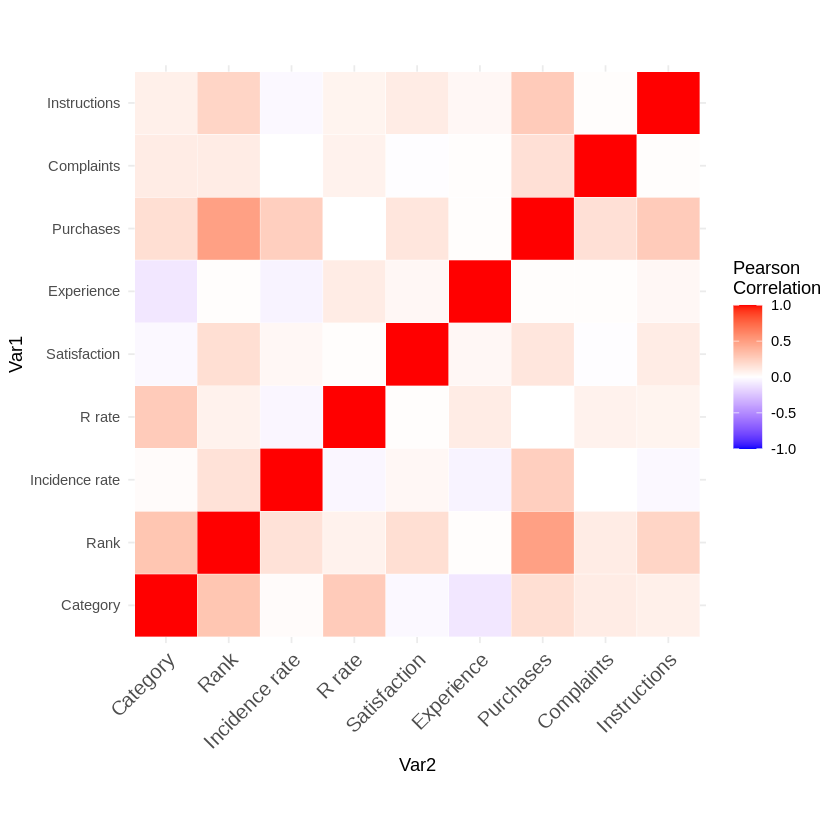

In [9]:
#correlation matrix
cormat <- round(cor(df[2:10]),2)
melted_cormat <- melt(cormat)
# heatmap plot
ggplot(data = melted_cormat, aes(Var2, Var1, fill = value))+
 geom_tile(color = "white")+
 scale_fill_gradient2(low = "blue", high = "red", mid = "white", 
   midpoint = 0, limit = c(-1,1), space = "Lab", 
   name="Pearson\nCorrelation") +
  theme_minimal()+ 
 theme(axis.text.x = element_text(angle = 45, vjust = 1, 
    size = 12, hjust = 1))+
 coord_fixed()

So now we can see the highest coefficients are between **Rank** and **Purchases**, need for **Instructions** and **Purchases** and **Incidence rate** and **Purchases**. The higher these parameters, the more purchases order the client. Correlation between Complaints and Purchases is also may be seen here, but it is weaker than correlations lised above.

In [10]:
lm2 <- lm(formula = Purchases ~ Rank + Instructions + Complaints + Satisfaction + Experience + df$'Incidence rate' + df$'R rate', data = df)
summary(lm2)


Call:
lm(formula = Purchases ~ Rank + Instructions + Complaints + Satisfaction + 
    Experience + df$"Incidence rate" + df$"R rate", data = df)

Residuals:
    Min      1Q  Median      3Q     Max 
-17.324  -4.335  -1.179   2.219 105.948 

Coefficients:
                     Estimate Std. Error t value Pr(>|t|)    
(Intercept)         -4.278409   1.477666  -2.895  0.00398 ** 
Rank                 1.965282   0.204320   9.619  < 2e-16 ***
Instructions         5.736973   1.311348   4.375 1.53e-05 ***
Complaints           0.654816   0.224792   2.913  0.00377 ** 
Satisfaction         0.008895   0.009562   0.930  0.35274    
Experience           0.177370   0.760612   0.233  0.81572    
df$"Incidence rate"  0.523147   0.110787   4.722 3.17e-06 ***
df$"R rate"         -0.670668   0.629889  -1.065  0.28759    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 9.513 on 429 degrees of freedom
Multiple R-squared:  0.3184,	Adjusted R-squared:  0.3073 
F-st

# 4. Define new doctor segments that help the company improve marketing efforts and customer service.


Clustering is the best solution for this type of problems. First we need to decide the number of clusters we want to get after clustering. Of course we can get as many clusters as we want, but there are some methods which gives you information on what number of clusters is the most appropriate for our data:

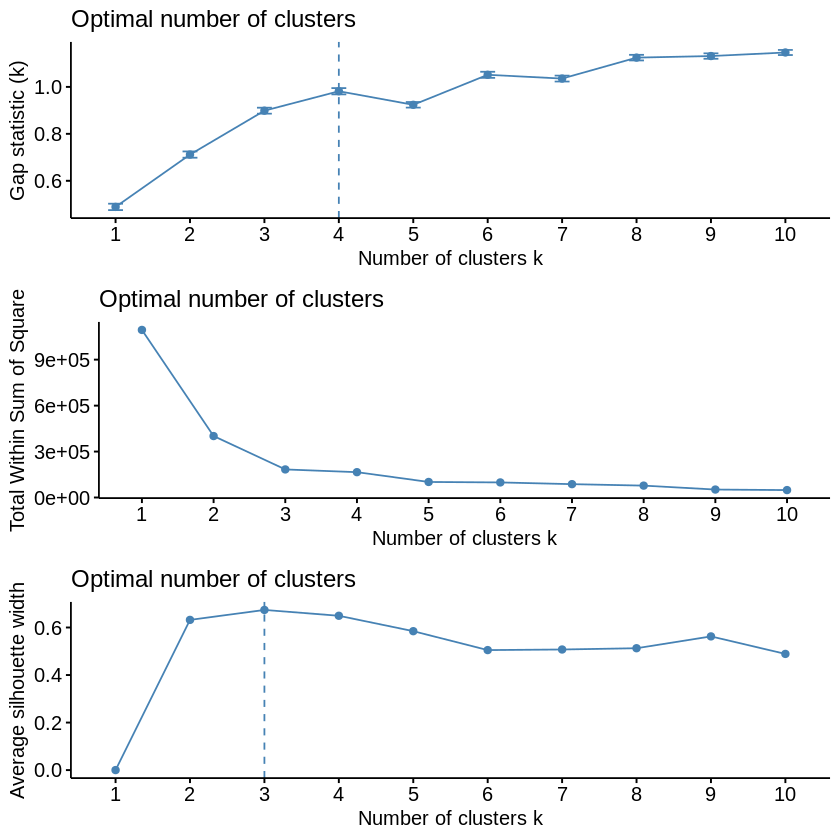

In [11]:
# choose the number of clusters
p1 <- fviz_nbclust(df[,2:10], kmeans, nstart = 9, method = "gap_stat") # optimal number of clusters by gap statistics
p2 <- fviz_nbclust(df[,2:10], kmeans, method = "wss") # elbow method
p3 <- fviz_nbclust(df[,2:10], kmeans, method = "silhouette") # silhouette method
grid.arrange(p1,p2,p3)

Different methods advice to divide the data on different number of groups. Let's look on these clusters:

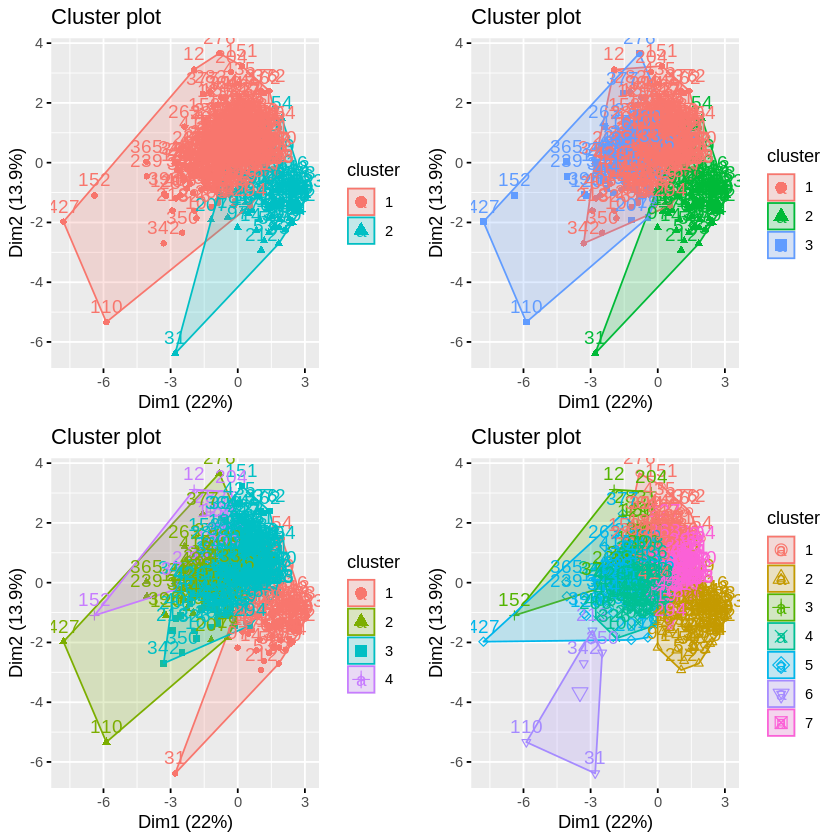

In [12]:
# k-means clustering with 2,3,4 and 7 clusters
df_clustering <- scale(df[,2:10]) #normalise
cl_number_2<-kmeans(df_clustering,2,nstart=25)
cl_number_3<-kmeans(df_clustering,3,nstart=25)
cl_number_4<-kmeans(df_clustering,4,nstart=25)
cl_number_7<-kmeans(df_clustering,7,nstart=25)
cl_number_2_plot<-fviz_cluster(cl_number_2,df_clustering)
cl_number_3_plot<-fviz_cluster(cl_number_3,df_clustering)
cl_number_4_plot<-fviz_cluster(cl_number_4,df_clustering)
cl_number_7_plot<-fviz_cluster(cl_number_7,df_clustering)
grid.arrange(cl_number_2_plot,cl_number_3_plot,cl_number_4_plot,cl_number_7_plot)


  cluster size ave.sil.width
1       1  367          0.24
2       2   70          0.29
  cluster size ave.sil.width
1       1  307          0.30
2       2   67          0.27
3       3   63          0.17
  cluster size ave.sil.width
1       1   67          0.26
2       2   61          0.17
3       3  290          0.33
4       4   19          0.23
  cluster size ave.sil.width
1       1   82          0.11
2       2   65          0.21
3       3   19          0.19
4       4  106          0.14
5       5   58          0.16
6       6    5          0.35
7       7  102          0.28


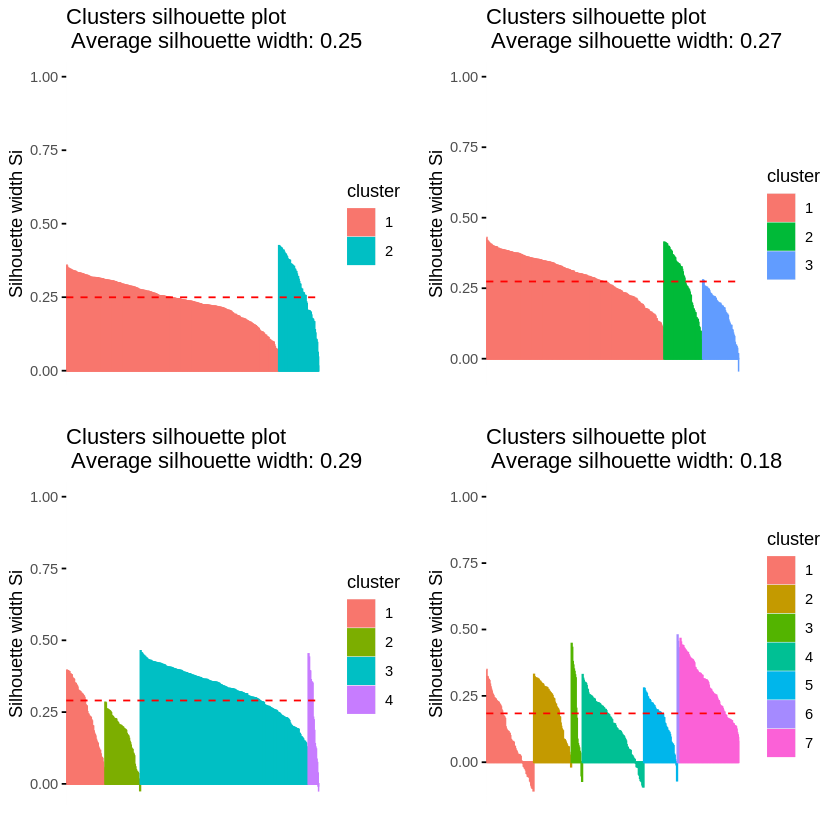

In [13]:
#checking clusterings results with silhouette plots
sil2 <- fviz_silhouette(silhouette(cl_number_2$cluster, dist(df_clustering)))
sil3 <- fviz_silhouette(silhouette(cl_number_3$cluster, dist(df_clustering)))
sil4 <- fviz_silhouette(silhouette(cl_number_4$cluster, dist(df_clustering)))
sil7 <- fviz_silhouette(silhouette(cl_number_7$cluster, dist(df_clustering)))
grid.arrange(sil2,sil3,sil4,sil7)

Silhouette analysis tells us that clustering with 4 clusters is the best decision because silhouette width is the biggest for 4 clusters.

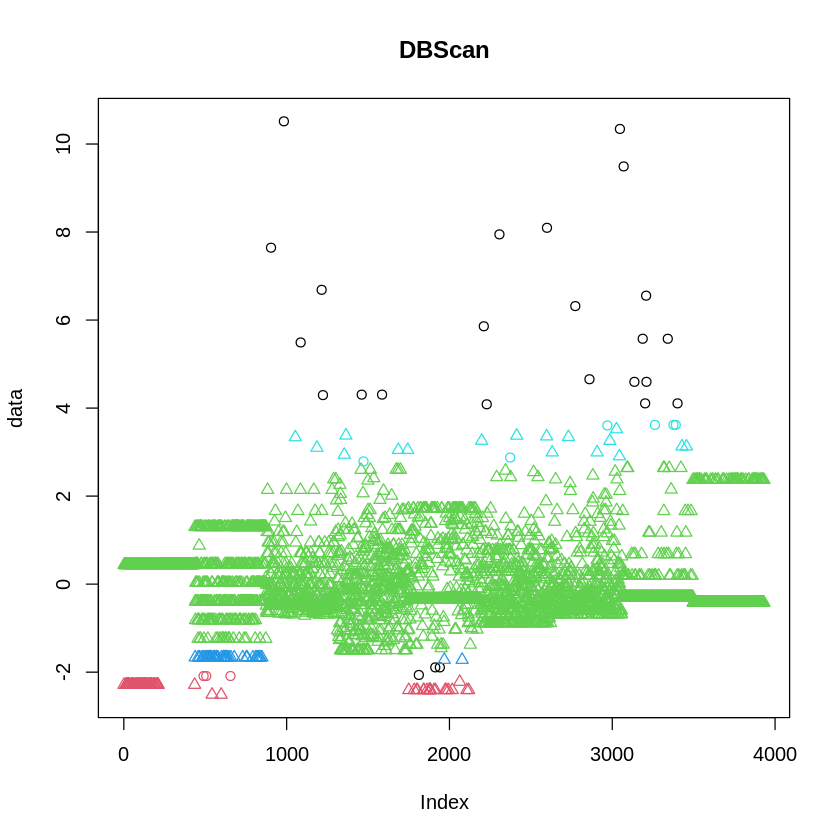

In [14]:
# clustering by density with DBScan
# fitting DBScan clustering Model 
df_clustering1 <- df_clustering[-1]
Dbscan_cl <- dbscan(df_clustering1, eps = 0.15, MinPts = 7, scale = FALSE, method = c("hybrid", "raw", "dist"))
# plotting Cluster
plot(Dbscan_cl, df_clustering1, main = "DBScan")

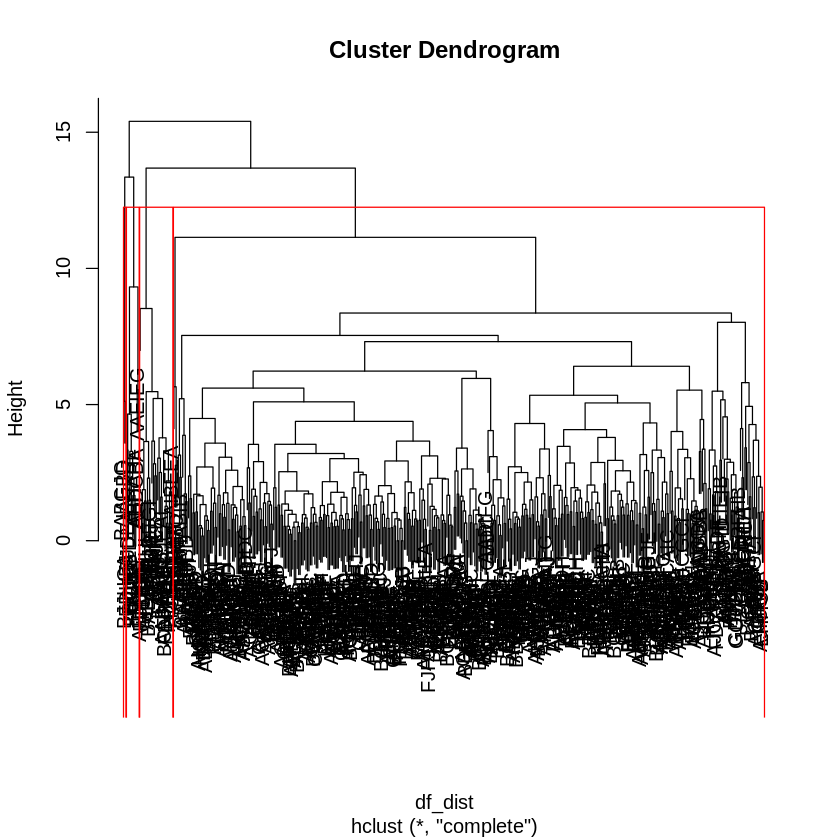

In [15]:
# Hierarchial clustering
# At the top of the tree there are characteristics which distinguish clusters the most
df_dist <- dist(df_clustering[,1:9])
x <- hclust(df_dist, method = "complete", members = NULL)
hc <- hclust(df_dist)
hc_clusters <- cutree(hc ,8)
plot(hc, labels=df$DoctorID)
rect.hclust(hc, k=4, border="red")

Different clustering methods show almost the same results: one big cluster which includes most occurences and several much smaller clusters. 
As a result, we used kmean clustering and got 4 clusters with sizes of 19, 61, 67 and 290 occurences. Cluster 4 is bigger than cluster 1 in 15 times! But there are some reasons why it's is important to pay attention to such a little group of clients.
Two pie charts show proportions of clusters and share of purchases per cluster. Cluster 1 which make up only 4% of all customers made 6% of all purchases last year! While cluster 2 which was 15% of all customers made only about 9% of all purhases last year.

In [16]:
df$cluster <- cl_number_4$cluster
cluster_4_1 <- filter(df, cluster == 1)
cluster_4_2 <- filter(df, cluster == 2)
cluster_4_3 <- filter(df, cluster == 3)
cluster_4_4 <- filter(df, cluster == 4)

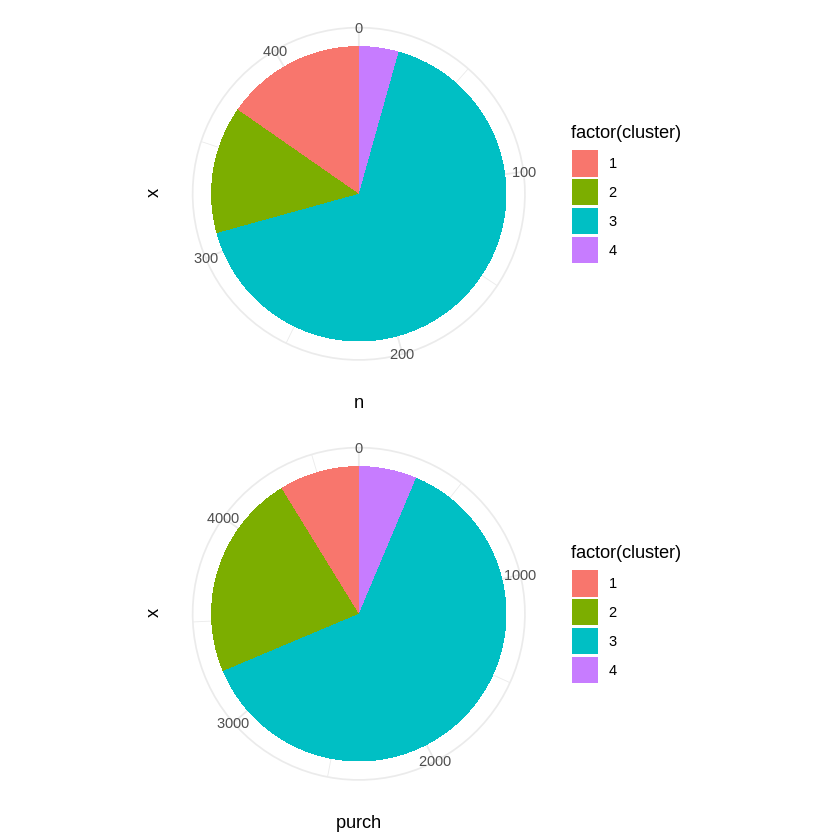

In [17]:
cluster_purchases <- dplyr::select(df, cluster, Purchases) %>% group_by(cluster) %>% summarise(n = n(), purch = sum(Purchases)) %>% as.data.frame()
cluster_purchases1 <- ggplot(cluster_purchases, aes(x = "", y = n, fill = factor(cluster))) +
  geom_col() +
  coord_polar(theta = "y")  +
  theme_minimal() 
cluster_purchases2 <- ggplot(cluster_purchases, aes(x = "", y = purch, fill = factor(cluster))) +
  geom_col()+
  coord_polar(theta = "y") +
  theme_minimal() 
grid.arrange(cluster_purchases1,cluster_purchases2) 

Category of doctor became one of the main determining factors for kmeans clustering: there are only general practitioners in the second cluster and mostly specialists in the others. Here are descriptions of each cluster with their given names:



Cluster 1 (4%) - **Experienced Customers** - consists of only *Specialists*, has one of the highest Ranks, high Incidence rate, great Experience, the biggest numbers of Purchases and Complaints. This group of clients makes many purchases but they also require great amount of re-work and send complaints much more often that any other clients 

Cluster 2 (15%) - **Generalists** - consists of only *Generalists*, has the lowest Rank among others, average Satisfaction level, makes the least amount of Purchases, has almost no Complaints and doesn't give additional Instructions. Considering their rather great Experience with the company and small amount of Purchases, we may assume, that Generalists order more rarely than Specialists. They also generate almost no re-work, don't have complaints and don't add instructions.

Cluster 3 (14%) - **Loyal Customers** - consists of mostly *Specialists* (95%), has the highest level in ranking program among other clusters, is satisfied with the company more than others, makes great amount of Purchases, has almost no Complaints, adds additional Instructions almost for all orders

Cluster 4 (66%) - **Newcomers** - consists of *Specialists* with Platinum Plus Rank, has little Experience with the company, never gives instructions, has almost no Complaints, orders less than other groups of Specialists, but more than Generalists, has one of the highest Incidence rate.

Here is plot with distribution of parameters divided by clusters:

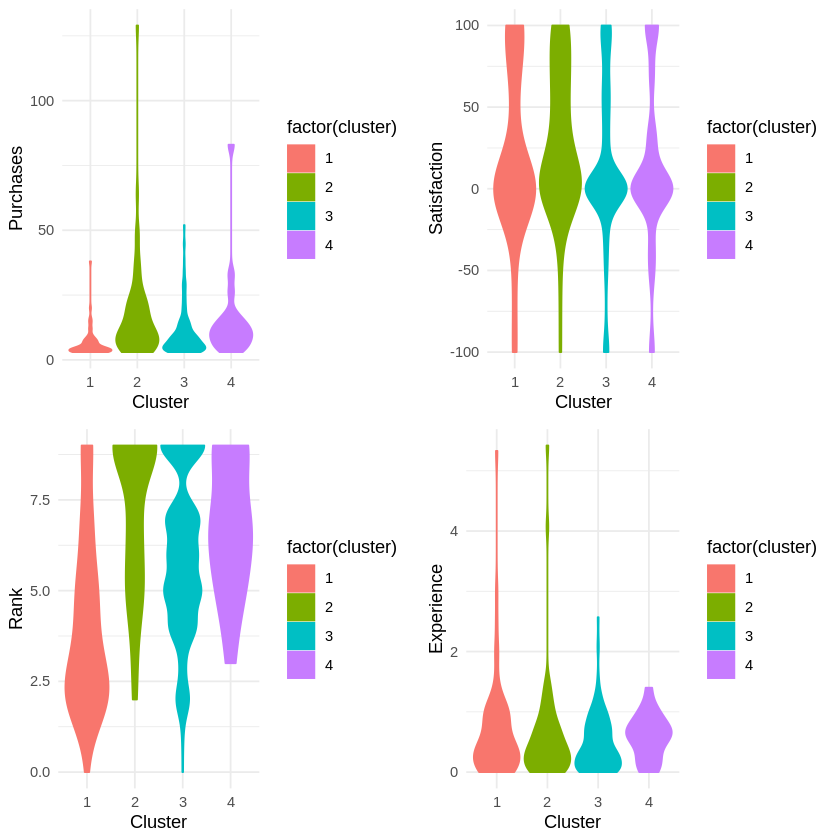

In [18]:
cl_purchases <- ggplot(df, mapping=aes(x=factor(cluster), y=Purchases,color = factor(cluster),fill = factor(cluster))) + geom_violin(scale = "width") + theme_minimal() + scale_x_discrete(name ="Cluster")
cl_satisfaction <- ggplot(df, mapping=aes(x=factor(cluster), y=Satisfaction,color = factor(cluster),fill = factor(cluster))) + geom_violin(scale = "width") + theme_minimal() + scale_x_discrete(name ="Cluster")
cl_rank <- ggplot(df, mapping=aes(x=factor(cluster), y=Rank,color = factor(cluster),fill = factor(cluster))) + geom_violin(scale = "width") + theme_minimal() + scale_x_discrete(name ="Cluster")
cl_experience <- ggplot(df, mapping=aes(x=factor(cluster), y=Experience,color = factor(cluster),fill = factor(cluster))) + geom_violin(scale = "width") + theme_minimal() + scale_x_discrete(name ="Cluster")
grid.arrange(cl_purchases, cl_satisfaction, cl_rank, cl_experience)

Thus, we may also notice that Loyal Customers who order and satisfied with the company the most, always give additional instructions. Probably this fact helps to raise satisfaction and number of purchases among other clients. Different stages of Customer Journey for different clusters may be revised. For example, Experienced Customers require more attention to their complaints and customer service, while Newcomers may have need more communication and information on the products and/or ranking system. If the company wants to raise number of Generalists it may offer some conditions which are different from Specialists'.

# Thanks for reading! Feedback is welcome